In [58]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from input_mapping.models_torch import get_model, model_dict
import optuna
import os
import json
from data_pipeline.image_transforms import get_transforms
from data_pipeline.data_loading import DfDataset
from ai_backend.evaluators.metrics.multi_label_metrics import multi_label_f_beta, multi_label_precision, multi_label_recal, multi_label_accuracy, multi_label_confusion_matrix
import logging
import multiprocessing

In [59]:
#turn warnings off
logging.getLogger('transformers.tokenization_utils').setLevel(logging.ERROR)

In [60]:
model_key = 'resnet18'
#set the operating point for the model
best_thresholds = 0.41000000000000003
#set torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
#get the model inference transforms
transform_config = model_dict[model_key]['transforms_config']
transform_type = 'standard'
inference_transforms = get_transforms(transform_name=transform_type, transforms_config=transform_config)

In [62]:
#load the dataset the model was trained on
with open('datasets/2024-01-31_11-09-02/dataset_config.json', 'r') as f:
    dataset_config = json.load(f)
data_path_col = dataset_config['path_to_img_coulumn']
label_cols = dataset_config['label_names']
all_train_data_path = 'datasets/2024-01-31_11-09-02/All_train.csv'
all_train_data = pd.read_csv(all_train_data_path)
all_train_dataset = DfDataset(all_train_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_train_loader = DataLoader(all_train_dataset, batch_size=32, shuffle=False)

In [63]:
#load the dataset which the model will be evaluated on
all_test_data_path = 'datasets/2024-01-31_11-09-02/All_test.csv'
all_test_data = pd.read_csv(all_test_data_path)
all_test_dataset = DfDataset(all_test_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_test_loader = DataLoader(all_test_dataset, batch_size=32, shuffle=False)

In [64]:
#all validation data
all_val_data_path = 'datasets/2024-01-31_11-09-02/All_validation.csv'
all_val_data = pd.read_csv(all_val_data_path)
all_val_dataset = DfDataset(all_val_data, transform=inference_transforms, data_path_col=data_path_col, label_cols=label_cols)
all_validation_loader = DataLoader(all_val_dataset, batch_size=32, shuffle=False)

In [65]:
#initialize the model
model_config_folder_path = 'models/resnet18/dd71346c-c91a-4516-9795-deb21cb897ff/'
#best ben:'models/resnet18/06eda80f-def7-4a4a-8d08-ef796f50e7a4/'
#best standard: 'models/resnet18/dd71346c-c91a-4516-9795-deb21cb897ff/'
#standard shown in ppt on 09.02.2024 'models/resnet18/6858584f-8c9e-483b-ac21-a01f7491e781/'
best_model_weights_path = f'{model_config_folder_path}best_model.pt'
n_classes = len(all_train_dataset.classes)
model = get_model(model_name=model_key, num_classes=n_classes, pretrained=False)
model.load_state_dict(torch.load(best_model_weights_path))
model.eval()


c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\elyes\miniconda3\envs\ird_deep_learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:
#get the predictions for the model
y_true_validation = []
y_pred_validation = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in all_validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true_validation.append(labels.detach().clone())
        y_pred_validation.append(outputs.detach().clone())
y_true_validation = torch.cat(y_true_validation, dim=0).cpu()
y_pred_validation = torch.cat(y_pred_validation, dim=0).cpu()

In [67]:

#define the objective function to find the best threshold
class objective:
    def __init__(self, y_true, y_pred, class_idx):
        self.y_true = y_true
        self.y_pred = y_pred
        self.class_idx = class_idx
    def __call__(self, trial):
        #get the threshold to use for the model
        threshold = trial.suggest_float('threshold', 0.0, 1.0, step=0.01)
        f1_score = multi_label_f_beta(self.y_true, self.y_pred, beta=1.0, averaging_type=None, threshold=threshold)
        return f1_score[self.class_idx].item()

In [ ]:
#find the best threshold for each label
#turn off optuna warnings
step_size = 0.01
iterations = 1/step_size

optuna.logging.set_verbosity(optuna.logging.ERROR)
best_thresholds = []

for i in range(len(label_cols)):
    best_thresholds.append(0)
    best_score = 0
    #todo fix the max function
    for j in range(int(iterations)):
        threshold = j*step_size
        f1_score = multi_label_f_beta(y_true_validation, y_pred_validation, beta=1.0, averaging_type=None, threshold=threshold)
        if f1_score[i] > best_score:
            best_score = f1_score[i]
            best_thresholds[i] = threshold
    print('Best thresholds found for class', label_cols[i], 'at', best_thresholds[i], 'with a score of', best_score)
#save the best thresholds
model_config = {
    'best_thresholds': best_thresholds
}
model_config_path = f'{model_config_folder_path}best_thresholds.json'
with open(model_config_path, 'w') as f:
    json.dump(model_config, f)
print('Model config saved')
#convert threshold to numpy array so they can be used to calculate the confusion matrix
best_thresholds = torch.Tensor(best_thresholds)



In [69]:
print('Best thresholds:', best_thresholds)
print(label_cols)

Best thresholds: tensor([0.3500, 0.5900, 0.1900, 0.2800, 0.0600, 0.1600, 0.0600, 0.1600, 0.1400,
        0.0800, 0.6600, 0.0800])
['Diabetic Retinopathy', 'Maculopathy', 'Normal', 'glaucoma', 'Bietti crystalline dystrophy', 'cataract', 'Stargardt Disease', 'Best Disease', 'Cone Dystrophie or Cone-rod Dystrophie', 'Retinitis Pigmentosa', 'Age-related Macular Degeneration', 'Myopia']


In [70]:
#execute the model on the test set
y_true = []
y_pred = []
model.to(device)
model.eval()
with torch.no_grad():
    for inputs, labels in all_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.append(labels.detach().clone())
        y_pred.append(outputs.detach().clone())
y_true = torch.cat(y_true, dim=0).cpu()
y_pred = torch.cat(y_pred, dim=0).cpu()

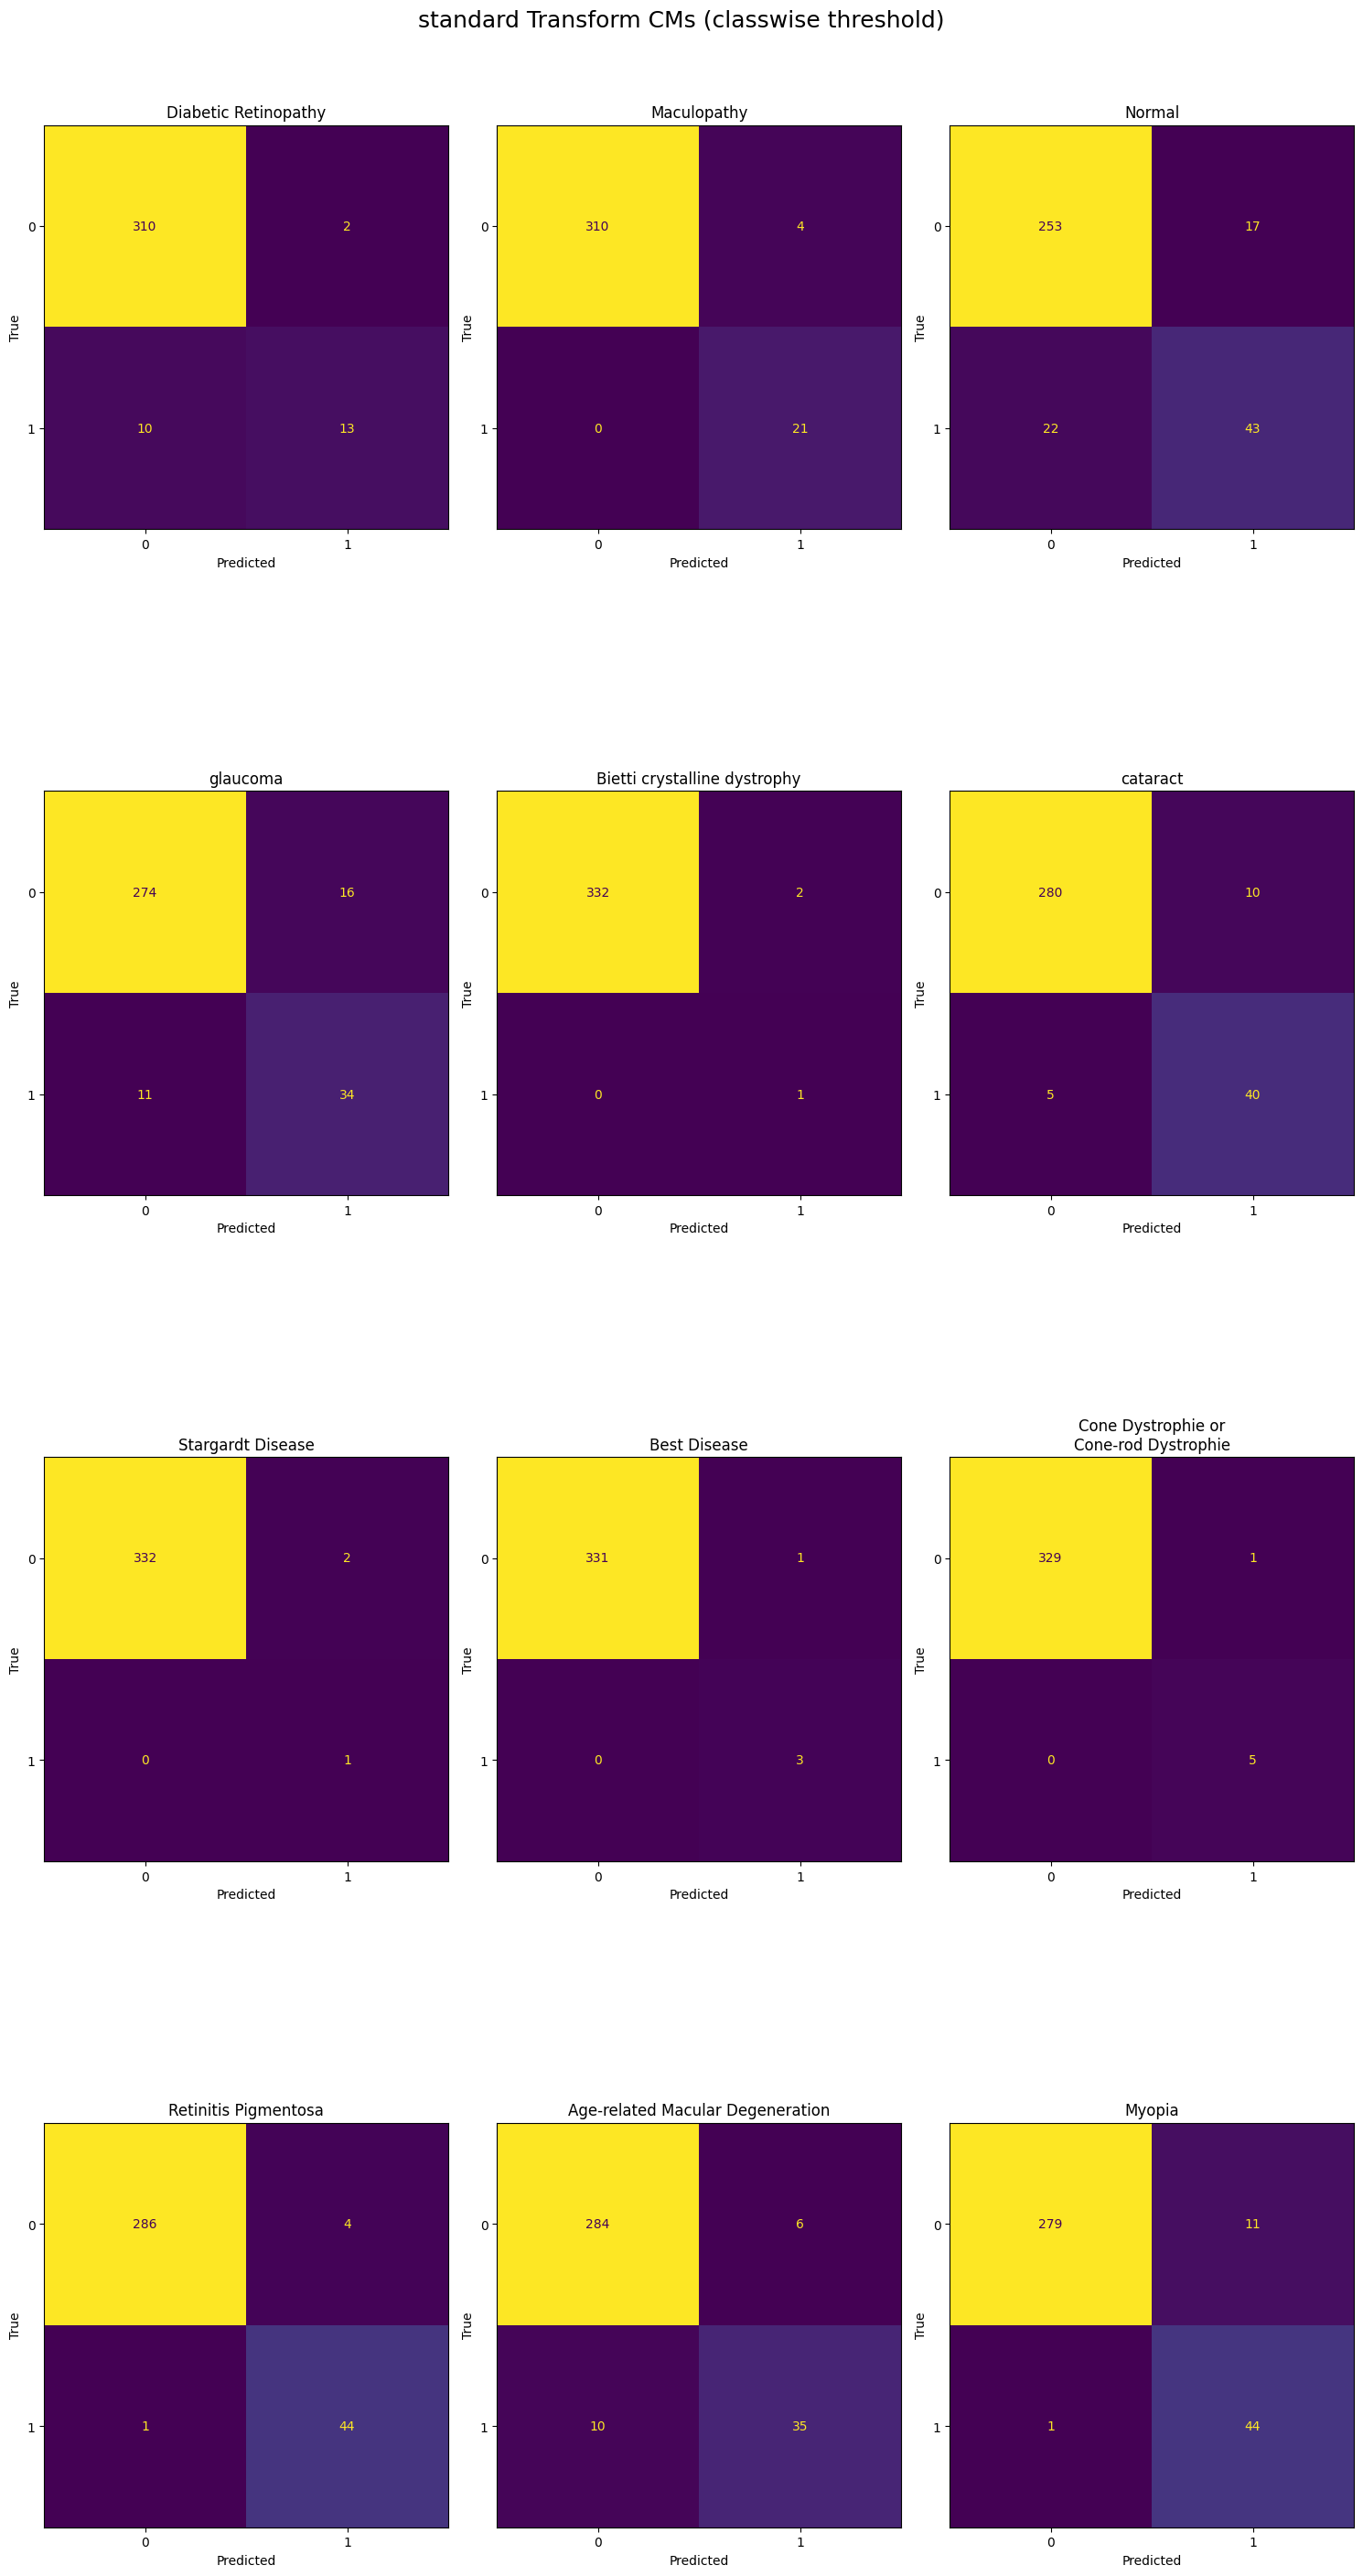

In [71]:
y_pred_cm = torch.sigmoid(y_pred) >best_thresholds
#calculate the confusion matrices on the test set
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_cm)
#plot the confusion matrices, one for each class, 3 per row
n_cols = 3
n_rows = int(np.ceil(len(all_train_dataset.classes) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 30))
axes = axes.flatten()
for i, ax in enumerate(axes):
    #use the confusion matrix to plot the confusion matrix
    cm = confusion_matrices[i]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #turn off color bar

    disp.plot(ax=ax, colorbar=False,values_format='d')
    title = all_train_dataset.classes[i]
    #split the title into multiple lines if it is too long
    if title.count(' ') > 2:
        #split every 3rd space
        title = title.split(' ')
        title = [' '.join(title[i:i+3]) for i in range(0, len(title), 3)]
        title = '\n'.join(title)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
plt.tight_layout()
plt.suptitle(f'{transform_type} Transform CMs (classwise threshold)', fontsize=18)
plt.show()

In [72]:
print(y_pred.size())
print(torch.sigmoid(y_pred[0,1]))
#define a function to calculate the f1 score from the confusion matrix
def f1_score_from_cm(tp : int, fp : int, fn : int):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

#test the f1 score function
print(f1_score_from_cm(tp = 35, fp = 7, fn = 10))
print(f1_score_from_cm(tp = 37, fp = 9, fn = 8))

torch.Size([335, 12])
tensor(0.0080)
0.8045977011494253
0.8131868131868132


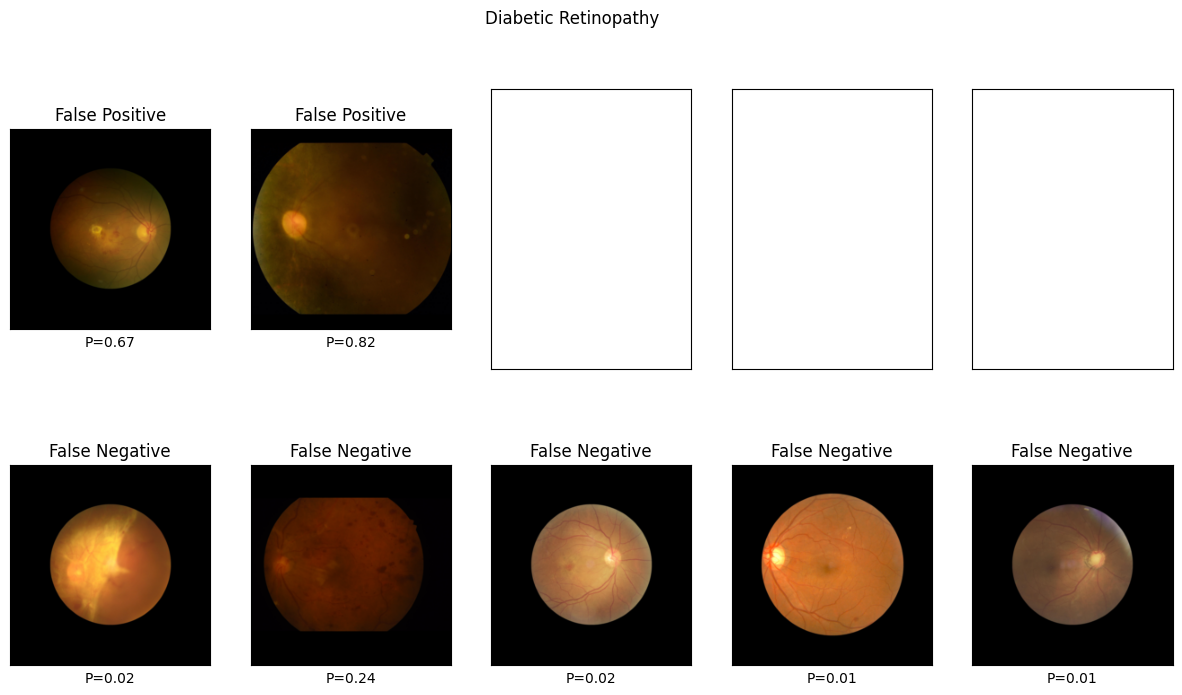

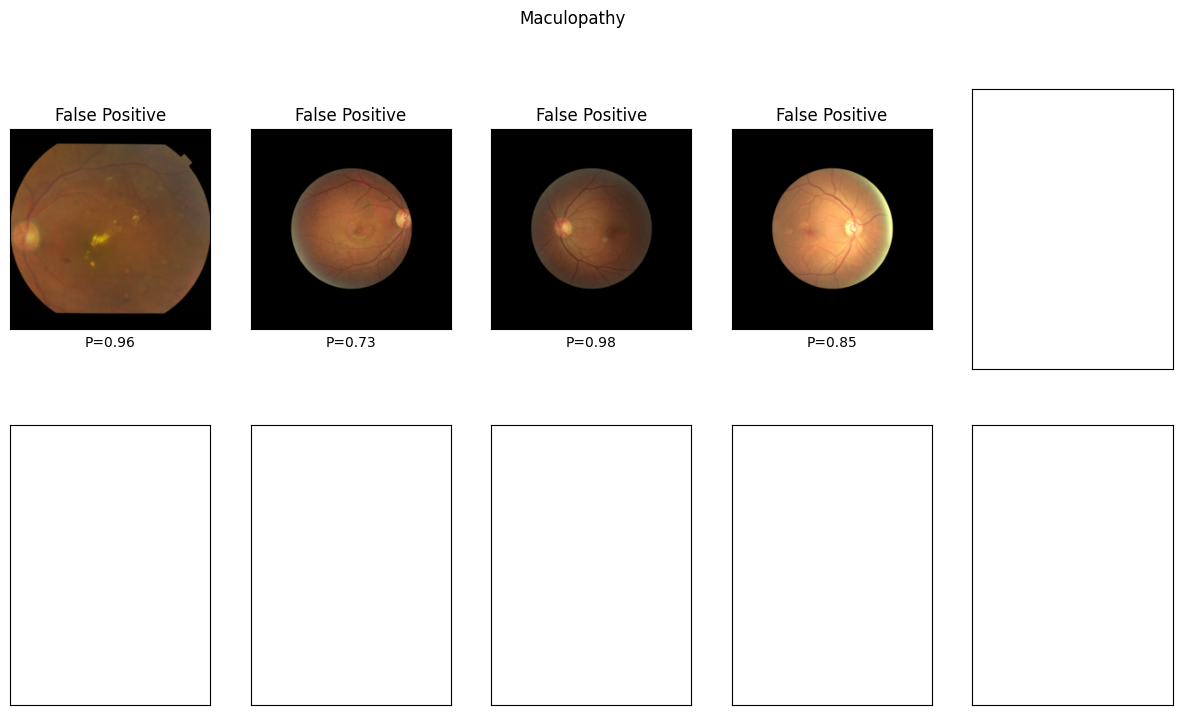

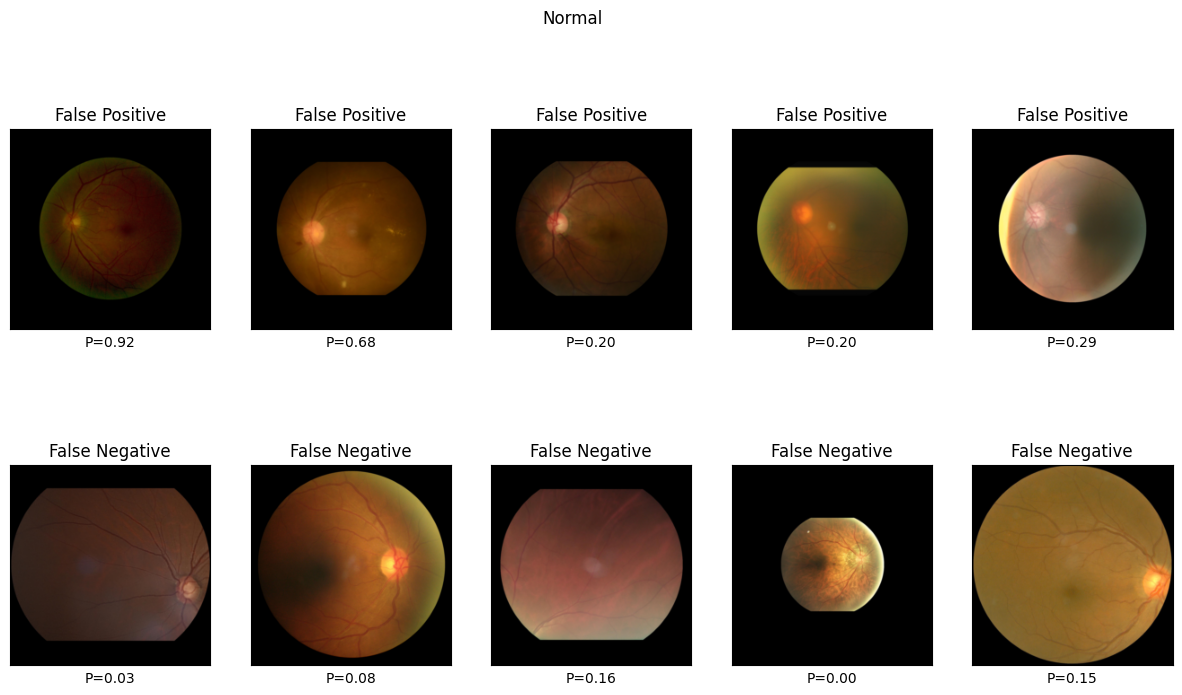

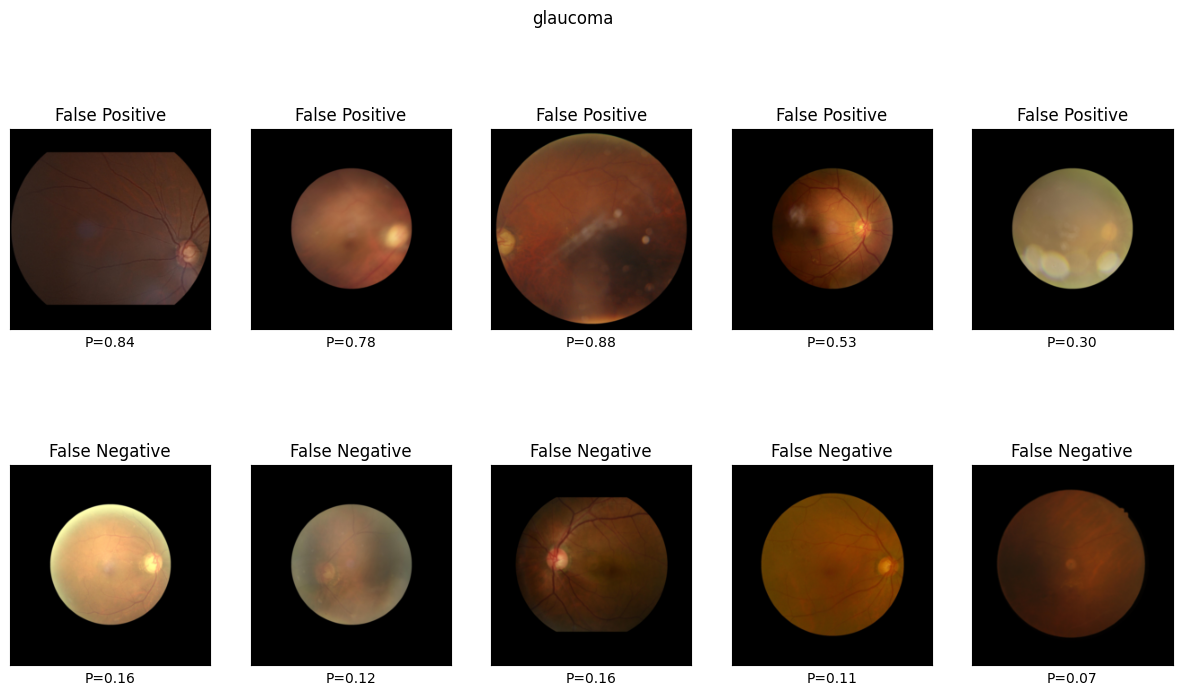

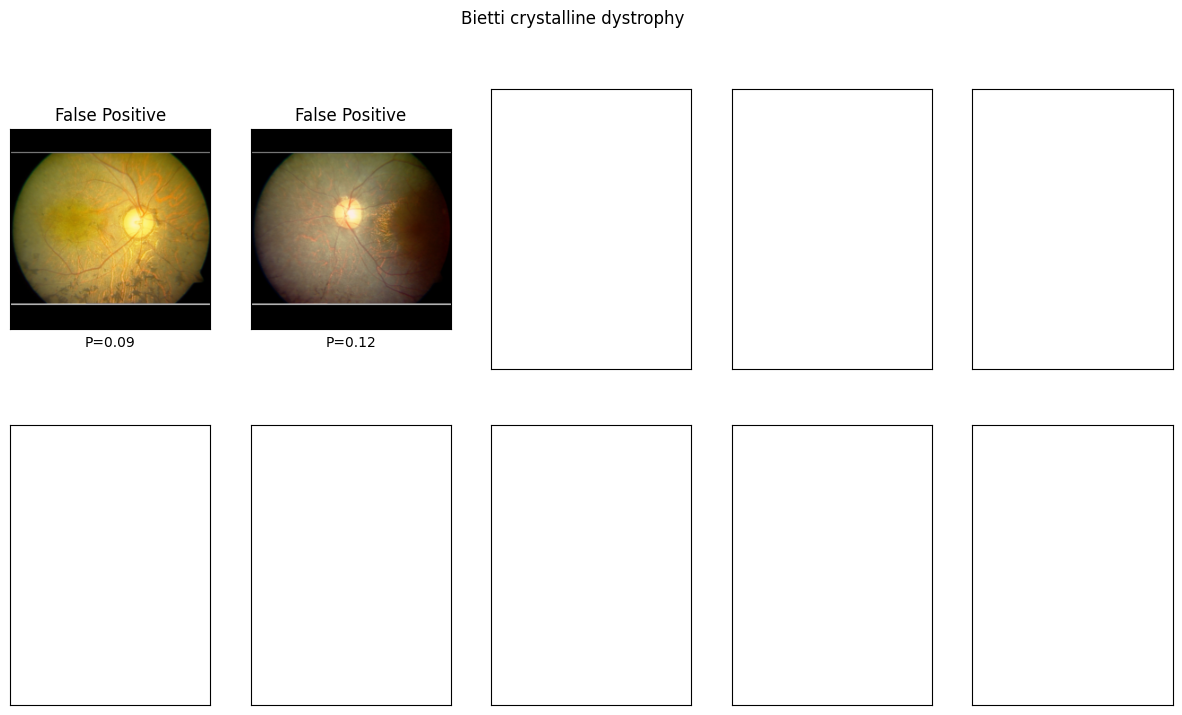

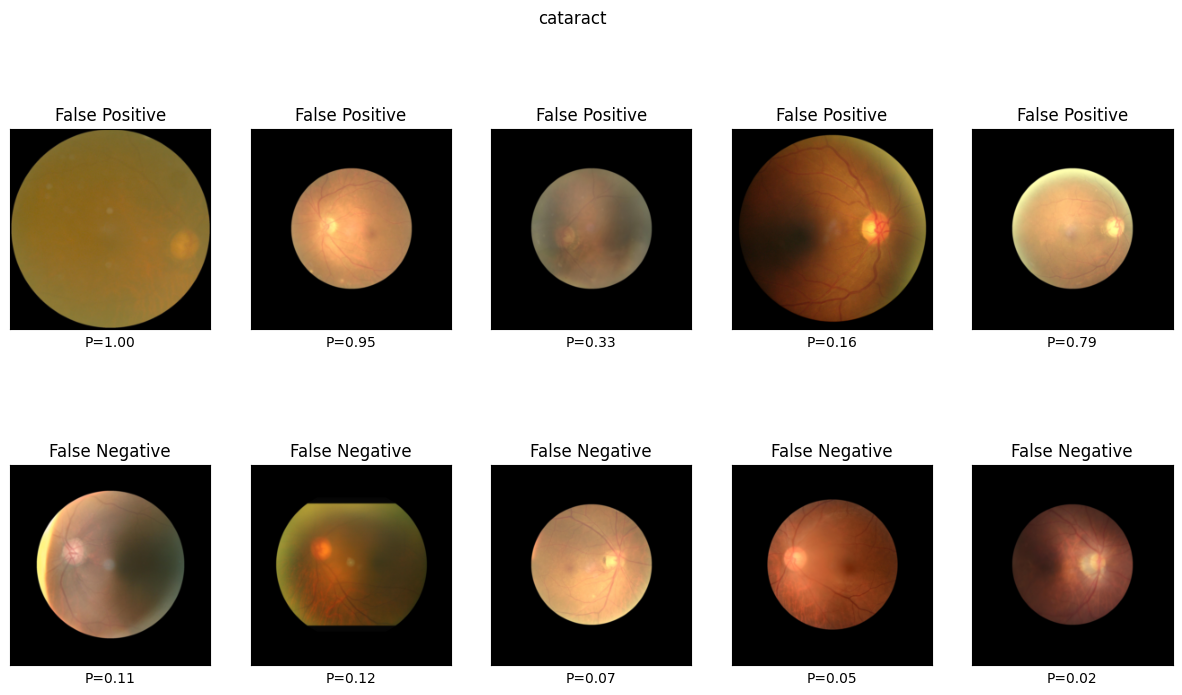

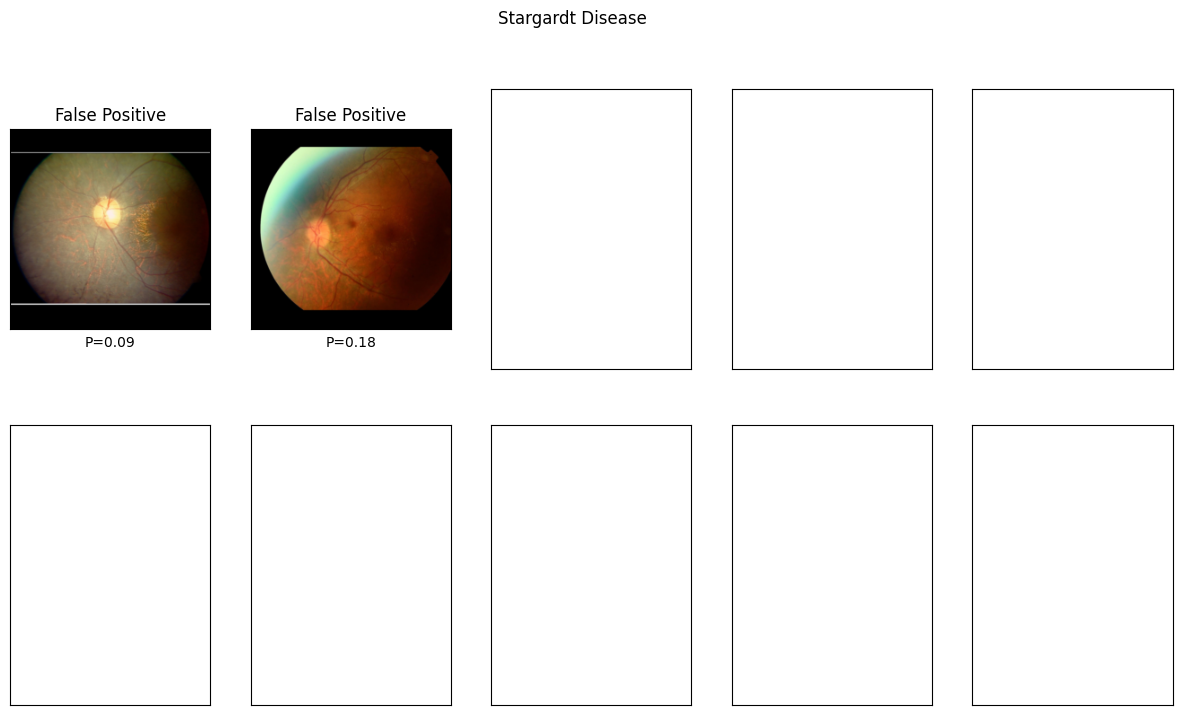

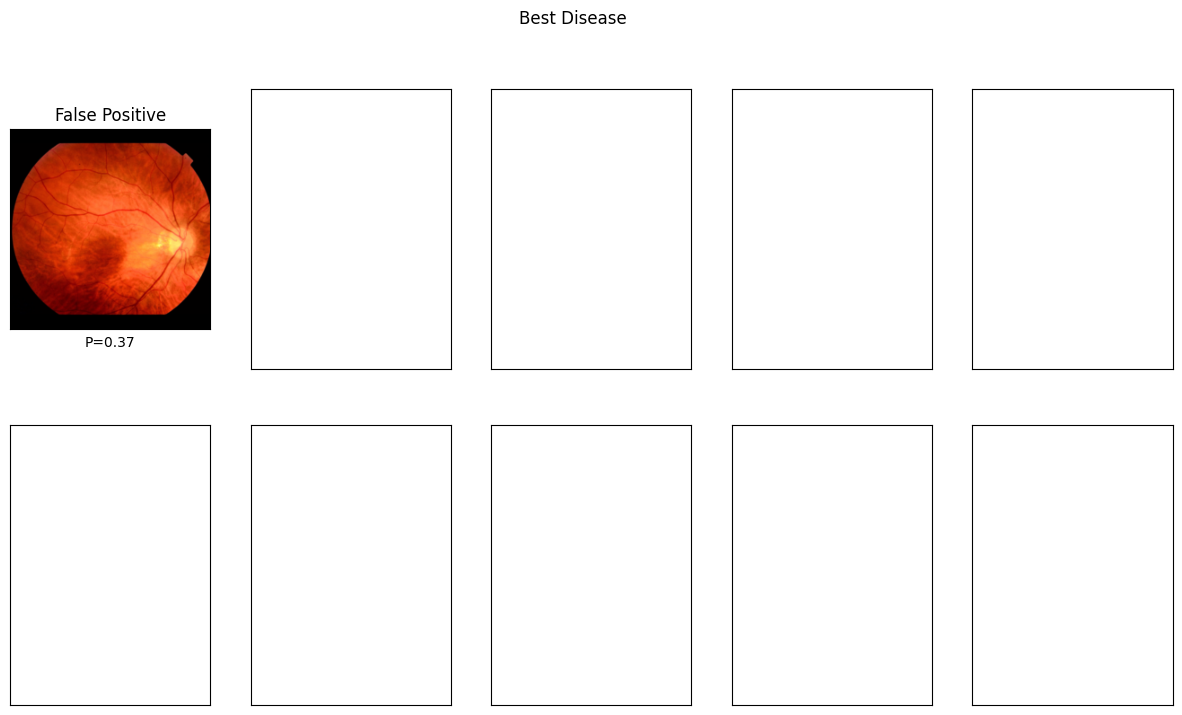

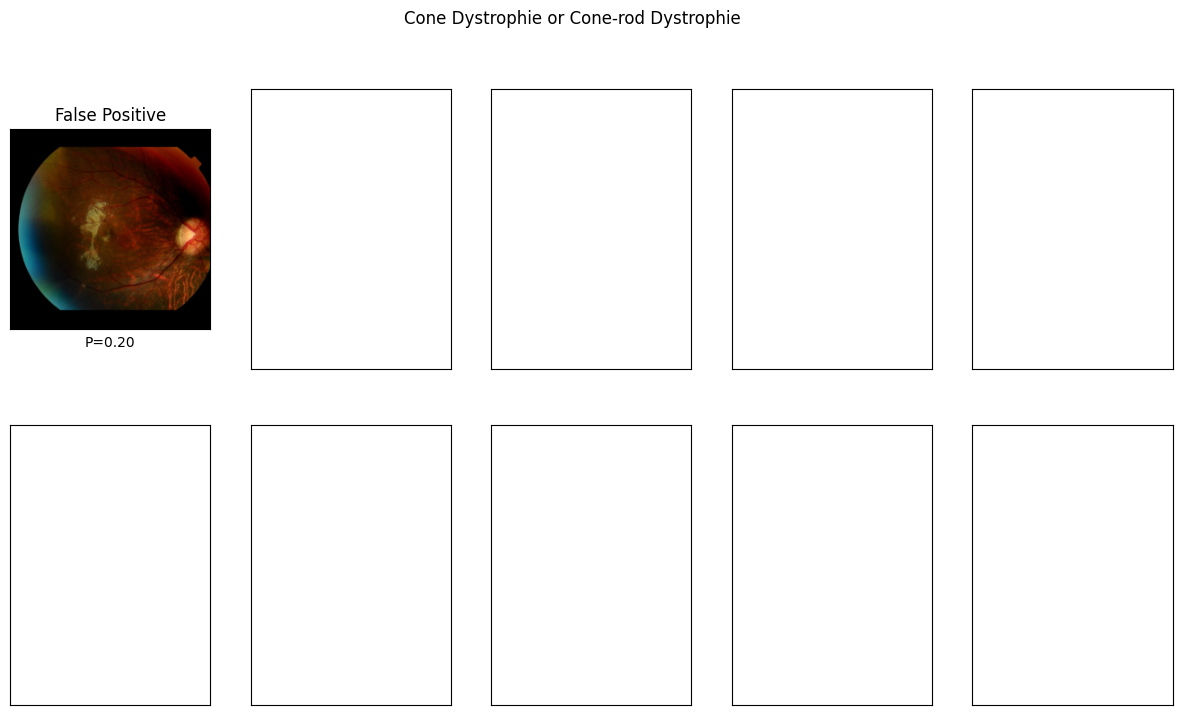

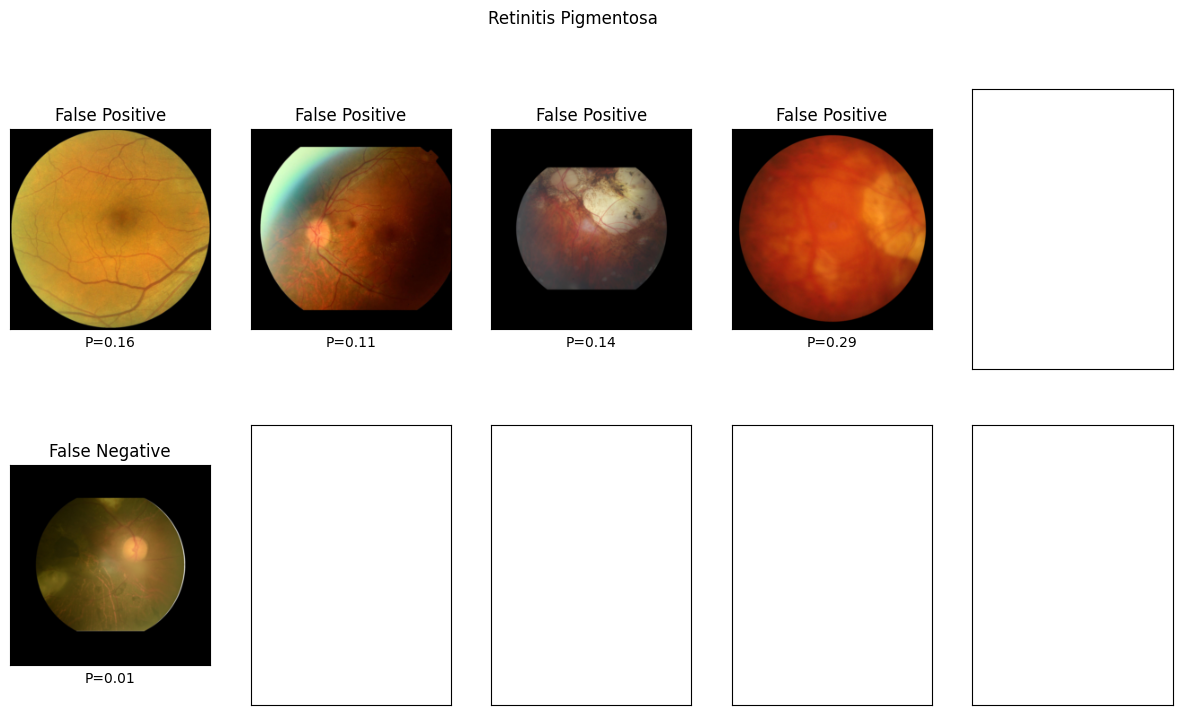

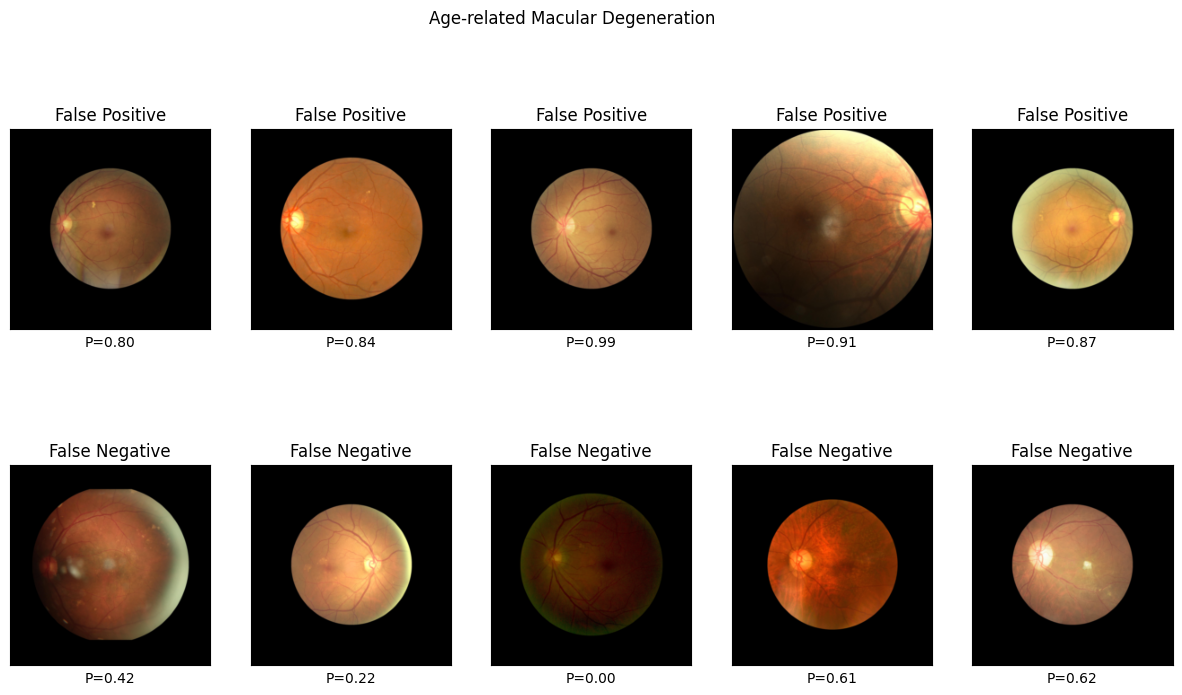

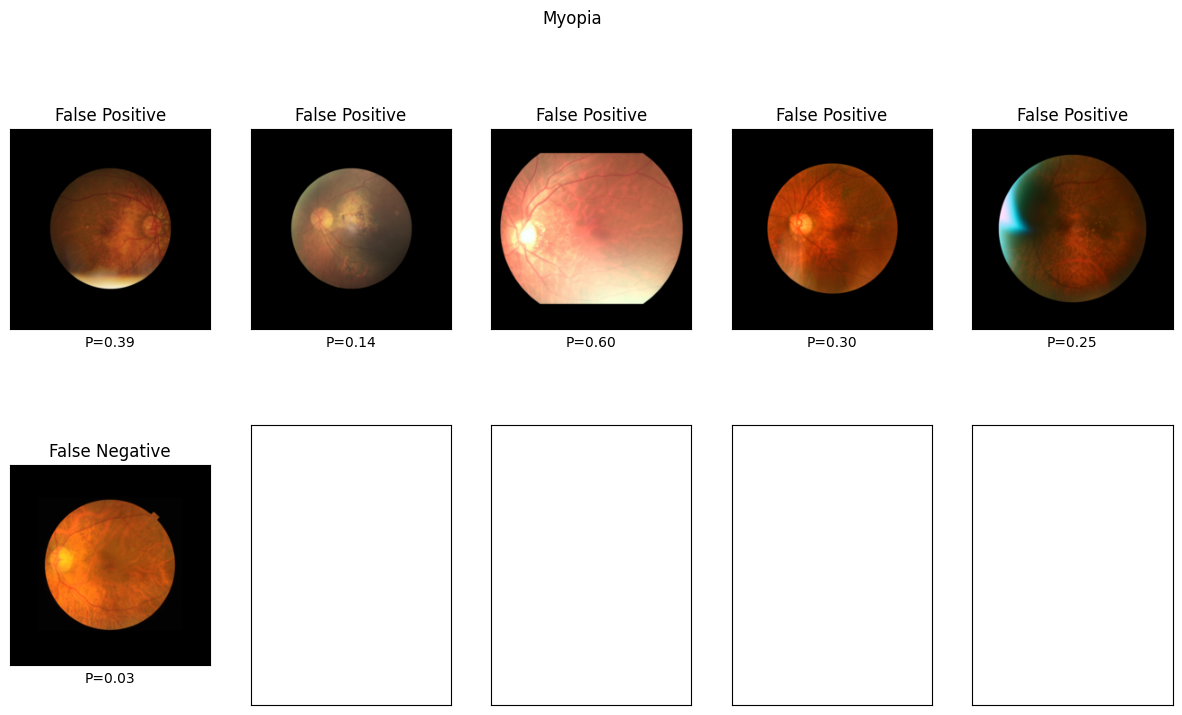

In [73]:
# Replace this with your actual data
all_train_dataset_classes = all_train_dataset.classes
n_categories_per_class = 2
n_images_per_category = 5
y_pred_prob = torch.sigmoid(y_pred)
for i, class_label in enumerate(all_train_dataset_classes):
    #filter the dataset to only images of the current class
    class_indices = torch.where(y_true[:, i] == 1)[0]
    #find the indices of the images which are fp and fn
    fp_indices = torch.where((y_true[:, i] == 0) & (y_pred_cm[:, i] == 1))[0]
    fn_indices = torch.where((y_true[:, i] == 1) & (y_pred_cm[:, i] == 0))[0]
    #get 5 random indices
    fp_indices = fp_indices[torch.randperm(len(fp_indices))[:5]].numpy()
    fn_indices = fn_indices[torch.randperm(len(fn_indices))[:5]].numpy()
    #get the images and labels from the test set
    fp_images = [all_test_dataset[i][0] for i in fp_indices]
    fn_images = [all_test_dataset[i][0] for i in fn_indices]
    #split ax into 5 subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    axes = axes.flatten()
    #turn off all axes ticks
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #plot the false positives and false negatives
    #check if fp and fn images have the same length
    if len(fp_images) >= 5 and len(fn_images) >= 5:
        for j, (fp_image, fn_image) in enumerate(zip(fp_images, fn_images)):
            axes[j].imshow(fp_image.permute(1, 2, 0))
            axes[j].set_title('False Positive')
            axes[j+5].imshow(fn_image.permute(1, 2, 0))
            axes[j+5].set_title('False Negative')
            #add probability of the image being in the class
            axes[j].set_xlabel(f'P={y_pred_prob[fp_indices[j], i]:.2f}')
            axes[j+5].set_xlabel(f'P={y_pred_prob[fn_indices[j], i]:.2f}')
    else:
        #run one loop for each
        for j, fp_image in enumerate(fp_images):
            axes[j].imshow(fp_image.permute(1, 2, 0))
            axes[j].set_title('False Positive')
            axes[j].set_xlabel(f'P={y_pred_prob[fp_indices[j], i]:.2f}')
        for j, fn_image in enumerate(fn_images):
            axes[j+5].imshow(fn_image.permute(1, 2, 0))
            axes[j+5].set_title('False Negative')
            axes[j+5].set_xlabel(f'P={y_pred_prob[fn_indices[j], i]:.2f}')
    #set a title for the class
    fig.suptitle(class_label)



#plt.tight_layout()
plt.show()

In [74]:
#show how many tp, fp, tn, fn there are in total
tp = confusion_matrices[:, 1, 1]
fp = confusion_matrices[:, 0, 1]
tn = confusion_matrices[:, 0, 0]
fn = confusion_matrices[:, 1, 0]
print(f'TP: {tp.sum()}')
print(f'FP: {fp.sum()}')
print(f'TN: {tn.sum()}')
print(f'FN: {fn.sum()}')
print('-----------------------------------')
best_thresholds = np.array(best_thresholds)
#calculate the precision, recall, accuracy and f1 score
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='macro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='macro', threshold=best_thresholds)
print(f'Precision macro: {precision:.2f}')
print(f'Recall macro: {recall:.2f}')
print(f'Accuracy macro: {accuracy:.2f}')
print(f'F1 macro: {f1:.2f}')
print('-----------------------------------')
#do the same for the micro scores
precision = multi_label_precision(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
recall = multi_label_recal(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
accuracy = multi_label_accuracy(y_true, y_pred, threshold=best_thresholds, averaging_type='micro')
f1 = multi_label_f_beta(y_true, y_pred, beta=1.0, averaging_type='micro', threshold=best_thresholds)
print(f'Precision micro: {precision:.2f}')
print(f'Recall micro: {recall:.2f}')
print(f'Accuracy micro: {accuracy:.2f}')
print(f'F1 micro: {f1:.2f}')


TP: 284
FP: 76
TN: 3600
FN: 60
-----------------------------------
Precision macro: 0.73
Recall macro: 0.88
Accuracy macro: 0.97
F1 macro: 0.80
-----------------------------------
Precision micro: 0.79
Recall micro: 0.83
Accuracy micro: 0.97
F1 micro: 0.81


In [75]:
#ben Best threshold: 0.41000000000000003
#normal Best threshold: 0.15